In [1]:
!pip install keras-cv tensorflow_datasets tensorflow==2.10.0 scikit-learn wandb keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394 kB 4.8 MB/s 
     |████████████████████████████████| 578.0 MB 14 kB/s 
     |████████████████████████████████| 1.9 MB 76.9 MB/s 
     |████████████████████████████████| 135 kB 92.3 MB/s 
     |████████████████████████████████| 5.9 MB 79.5 MB/s 
     |████████████████████████████████| 438 kB 81.0 MB/s 
     |████████████████████████████████| 1.7 MB 78.9 MB/s 
     |████████████████████████████████| 182 kB 81.1 MB/s 
     |████████████████████████████████| 168 kB 83.2 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 168 kB 83.9 MB/s 
     |████████████████████████████████| 166 kB 89.9 MB/s 
     |████████████████████████████████| 166 kB 91.4 MB/s 
     |████████████████████████████████| 162 kB 75.7 MB/s 
     |████████████████████████████████| 162 kB 85.6 MB/s 
     |████████████████████████████

In [4]:
from tensorflow.keras.layers import (Conv2D  , Concatenate , concatenate , 
   GlobalAveragePooling2D  , Normalization, BatchNormalization , Activation   , AveragePooling2D  ,
    MaxPooling2D, ZeroPadding2D , Dense , Add , ZeroPadding2D  , Input ,Flatten , Reshape , Dropout , Multiply , SpatialDropout2D)
from tensorflow.keras.models import Model , Sequential
import tensorflow as tf 
import tensorflow.keras.backend as K 
from tensorflow.keras import mixed_precision
from tensorflow.keras.regularizers import L2 , l2
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from sklearn.model_selection import train_test_split
import gc

In [2]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
import numpy as np 

label_mapping ={ 0: 'aquatic_mammals',

1: 'fish',

2: 'flowers',

3: 'food_containers',

4: 'fruit_and_vegetables',

5: 'household_electrical_devices',

6: 'household_furniture',

7: 'insects',

8: 'large_carnivores',

9: 'large_man-made_outdoor_things',

10: 'large_natural_outdoor_scenes',

11: 'large_omnivores_and_herbivores',
12: 'medium_mammals',

13: 'non-insect_invertebrates',

14: 'people',

15: 'reptiles',

16: 'small_mammals',

17: 'trees',

18:' vehicles_1',

19: 'vehicles_2'}
def class_analysis(model, X_val , y_val):
    finalpredictions = model.predict(X_val)
   
    finalpredictions_final=np.argmax(finalpredictions, axis=1)
    y_test_final=np.argmax(y_val, axis=1) if y_val.ndim == 2 else y_val
    classificationresults = classification_report(y_test_final ,finalpredictions_final  , target_names = label_mapping.values() , output_dict =True)
    print('Accuracy' , accuracy_score(y_test_final ,finalpredictions_final ))
    return pd.DataFrame(classificationresults).T.sort_values('f1-score')



# [Dense Net](https://arxiv.org/pdf/1608.06993v5.pdf)




![link text](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-20_at_11.35.53_PM_KroVKVL.png)


- The connections are similar to the resnet, except the resnet uses addition operation and the dense net uses concatenation 

- Dense net paper authors suggested that the addition operator might 'impede the information flow in the network' 

- The architecture also includes transition blocks with max pooling layers to decrease the dimensions of the image by half

- Bottleneck blocks (extra 1x1 convolution)  with compression value of 0.5 to reduce the number of feature maps by half  in each transition layer, Dense net with bottleneck blocks and compression are "Dense Net BC"
- I choose the smallest Dense Net BC with depth of 100 and increasing factor of 12 as Dense Nets are memory intensive 

In [5]:


# tf.config.gpu.set_per_process_memory_fraction(0.75)
# tf.config.gpu.set_per_process_memory_growth(True)

K.clear_session()

REGULARISATION = 1e-4
class Dense_conv(Model):
    def __init__(self , no_channels , bottleneck):
        super().__init__()
        self.concat = Concatenate()
        self.bottleneck = bottleneck
        self.bn1 = BatchNormalization()
        self.activation = Activation('relu')
        if bottleneck:
            # print('bottleneck')
            self.conv1 = Conv2D(no_channels*4, (1, 1) , kernel_regularizer = L2(REGULARISATION), kernel_initializer='he_normal', padding='same', use_bias=False)
            self.bn2 = BatchNormalization()
        self.conv2 = Conv2D(no_channels, (3, 3), kernel_regularizer = L2(REGULARISATION), kernel_initializer='he_normal', padding='same', use_bias=False)
        self.dropout = SpatialDropout2D(0.2)
        self.dropout2 = SpatialDropout2D(0.2)



    def call(self, x):


        branch1 = self.bn1(x)
        branch1 = self.activation(branch1)

        if self.bottleneck:
            branch1 = self.conv1(branch1)
            branch1 = self.dropout(branch1)

            branch1 = self.bn2(branch1)

        branch1 = self.conv2(branch1)
        branch1 = self.dropout2(branch1)



        return branch1



class TransitionBlock(Model):
    def __init__(self, n_channels):
        super().__init__()
        self.bn1 = BatchNormalization()
        self.activation = Activation('relu')
        self.conv = Conv2D(n_channels , (1,1) , kernel_regularizer = L2(REGULARISATION), padding = 'same' , use_bias = False)
        self.pooling = AveragePooling2D(2,strides = 2 )
        self.dropout = SpatialDropout2D(0.1)


    

    def call(self, x):
        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv(x)
        x= self.dropout(x)
        x = self.pooling(x)
        return x 
class SE(Model):
    def __init__(self, n_channels , ratio = 16):
        super().__init__()
        self.pool = GlobalAveragePooling2D()
        self.reshape = Reshape((1,1,n_channels))
        self.dense1 = Dense(n_channels // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)
        self.dense2 = Dense(n_channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)

    def call(self,x):
        branch1 = self.pool(x)
        branch1 =self.reshape(branch1)
        branch1 =self.dense1(branch1)
        branch1 =self.dense2(branch1)
        return Multiply()([x, branch1])




class DenseNetFactory:

    def __init__(self):
        pass 



    def squeeze_excite_block(self,input_tensor, ratio=16):
        """ Create a channel-wise squeeze-excite block
        Args:
            input_tensor: input Keras tensor
            ratio: number of output filters
        Returns: a Keras tensor
        References
        -   [Squeeze and Excitation Networks](https://arxiv.org/abs/1709.01507)
        """
        init = input_tensor
        filters =  init.shape[-1]
        se_shape = (1, 1,init.shape[-1])

        se = GlobalAveragePooling2D()(init)
        se = Reshape(se_shape)(se)
        se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
        se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

        x = Multiply()([init, se])
        return x

    

    def _dense_block(self , x, n, bottleneck ):

        outputs = [x]
        for _ in range(n):
            temp = Dense_conv(self.growthrate , bottleneck)(x)
            outputs.append(temp)
            self.n_filters += self.growthrate
            x = Concatenate()([x, temp  ])
        # x =self.squeeze_excite_block(x)
        return x



    def createdensenet(self , depth , growthrate  , commpresion ,bottleneck, n_classes = 20 , inputshape = (32,32,3) ):

        
        self.n_filters = 16

        self.growthrate = growthrate
        assert (depth -4) %3 ==0 , ' (depth -4) %3 must be equal to 0 '
        n = (depth -4) /3 
        if bottleneck:n/=2
        input = Input(inputshape)
        x = Conv2D(self.n_filters, 3, strides = 1  , padding = 'same' , use_bias = False)(input)
        for _ in range(2):
            x = self._dense_block(x, int(n) , bottleneck)
            self.n_filters *= commpresion
            self.n_filters = int(self.n_filters)
            x = TransitionBlock(self.n_filters)(x)
            # x = self.squeeze_excite_block(x)
        x = self._dense_block(x , int(n)  , bottleneck)
        x= BatchNormalization()(x)
        x= Activation('relu')(x)
        x= GlobalAveragePooling2D()(x)

        x=  Dense(n_classes , activation = 'softmax' , dtype = 'float32' )(x)


        return Model( inputs = [input ] , outputs = [x])

    

densenet = DenseNetFactory().createdensenet(100, 12  ,0.5, bottleneck = True)
        

densenet.build((None, 32,32,3))

densenet.compile(loss = 'categorical_crossentropy' , optimizer = tf.keras.optimizers.SGD(
    learning_rate = 0.3  , nesterov = True ,momentum = 0.9 ) , metrics = ['categorical_accuracy'])


In [6]:
dummyinput= Input((32,32,3))

# Model(inputs = [dummyinput] , outputs = [densenet.call(dummyinput)]).summary()
densenet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   432         ['input_1[0][0]']                
                                                                                                  
 dense_conv (Dense_conv)        (None, 32, 32, 12)   6208        ['conv2d[0][0]']                 
                                                                                                  
 concatenate_1 (Concatenate)    (None, 32, 32, 28)   0           ['conv2d[0][0]',                 
                                                                  'dense_conv[0][0]']         

In [7]:

IMG_SIZE =32
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) 
    return image, label


@tf.function
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1

    target_h_new = tf.cond(target_h ==0 , lambda : target_h+1,  lambda :target_h)
    print(type(target_h))
    # if target_h == 0:
    #     target_h += 1

    target_w = bbx2 - boundaryx1
    target_w_new = tf.cond(target_w ==0 , lambda:target_w+1, lambda:target_w)
    print(target_w)

    # if target_w == 0:
    #     target_w += 1

    return boundaryx1, boundaryy1, target_h_new, target_w_new


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [1]
    beta = [1]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label


In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data('coarse')
x_train = x_train/255.0
x_test = x_test/255.0

y_train= tf.keras.utils.to_categorical(y_train, num_classes=20)
y_test= tf.keras.utils.to_categorical(y_test, num_classes=20)


train_and_val_size = len(x_train) 

print(train_and_val_size)
trainsize= int(0.8*train_and_val_size)

# trainandval = tf.data.Dataset.from_tensor_slices((x_train ,y_train )).shuffle(train_and_val_size)
test = tf.data.Dataset.from_tensor_slices((x_test ,y_test ))

# train = trainandval.take(trainsize)
# val = trainandval.skip(trainsize )
X_actual_train, X_val, y_actual_train, y_val = train_test_split(  x_train, y_train, test_size=0.2, random_state=42)

train = tf.data.Dataset.from_tensor_slices((X_actual_train ,y_actual_train ))
val = tf.data.Dataset.from_tensor_slices((X_val ,y_val ))



simpleaugpipeline = Sequential([
    tf.keras.layers.RandomCrop(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.RandomFlip(mode = 'horizontal'),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomZoom(0.2,0.2)

])


train = train.map(preprocess_image)

# train_augmented_simple = train.map(lambda img,label: (simpleaugpipeline(img) , label), num_parallel_calls=tf.data.AUTOTUNE)


train_augmented = tf.data.Dataset.zip((train.shuffle(1024) , train.shuffle(1024) )).map(cutmix  , num_parallel_calls=tf.data.AUTOTUNE)
                                
def helper(*datasets):
    imgs = [i[0] for i in datasets]
    labels = [i[1] for i in datasets]

    return tf.stack(imgs), tf.stack(labels)

datasets_zipped = tf.data.Dataset.zip((train_augmented,  ))
datasets_zipped_tensor = datasets_zipped.map(helper).unbatch().map(preprocess_image).batch(64).prefetch(tf.data.AUTOTUNE)



169001437/169001437 [==============================] - 2s 0us/step
50000
<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("sub_4:0", shape=(), dtype=int32)


### ReduceLROnPlateau

The loss and accuracy  will stagnent when the training reaches an minimum point and the loss function will hover around the same value, using `ReduceLROnPlateau`,to derease the learning rate will cause the loss function to be fine tuned more.


I decided to use a `patience` of 4 epochs and monitor the `val_categorical_accuracy`. Everytime the the performance pleateaus, the 


### Batchsize
- I decrease the batchsize from normal value of 128 to 64 as the Dense Net is more memory intensive





Cutmix Augmentation

- Cutmix Augmentation randomly overlays images on one another and by a certain proprotion and the one hot encoded labels are also mixed

- For e.g, if image1 from class 1 is overlayed on image 2 from class 2 , the one hot encoded label for that image might be [ 0.2, 0.8] where 20% of the original image is covered by another image

In [9]:

  
class ClearMemoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
# history = sampyramid.fit( train.batch(128).map(augment_data) , validation_data = val.batch(64).map(onehotval), epochs = 10 )
import numpy as np 


class ClearMemoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
import wandb
wandb.login(key ='af6f4c85343fbc8359ab0fe7b2e1d8e4afd00896')
wandb.init( project ='dense cifar ')
from wandb.keras import WandbCallback
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy' , factor = 0.35  , patience=4), tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy' , patience=8), ClearMemoryCallback() ,WandbCallback() ]

try:
    history = densenet.fit( datasets_zipped_tensor , validation_data = val.batch(64), epochs = 100  , callbacks = callbacks)
except :
    densenet.save('mydensenet3')


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yh1234. Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 3.3283 - categorical_accuracy: 0.1318

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 136s 180ms/step - loss: 3.3283 - categorical_accuracy: 0.1318 - val_loss: 3.0065 - val_categorical_accuracy: 0.1705 - lr: 0.3000
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 2.9882 - categorical_accuracy: 0.1789

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 116s 179ms/step - loss: 2.9882 - categorical_accuracy: 0.1789 - val_loss: 2.7133 - val_categorical_accuracy: 0.2219 - lr: 0.3000
Epoch 3/100
625/625 [==============================] - ETA: 0s - loss: 2.8288 - categorical_accuracy: 0.2044

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 116s 180ms/step - loss: 2.8288 - categorical_accuracy: 0.2044 - val_loss: 2.5572 - val_categorical_accuracy: 0.2529 - lr: 0.3000
Epoch 4/100
625/625 [==============================] - ETA: 0s - loss: 2.7440 - categorical_accuracy: 0.2239

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 116s 180ms/step - loss: 2.7440 - categorical_accuracy: 0.2239 - val_loss: 2.4314 - val_categorical_accuracy: 0.2741 - lr: 0.3000
Epoch 5/100
625/625 [==============================] - 57s 85ms/step - loss: 2.6924 - categorical_accuracy: 0.2351 - val_loss: 2.4749 - val_categorical_accuracy: 0.2726 - lr: 0.3000
Epoch 6/100
625/625 [==============================] - ETA: 0s - loss: 2.6608 - categorical_accuracy: 0.2499

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 114s 178ms/step - loss: 2.6608 - categorical_accuracy: 0.2499 - val_loss: 2.4007 - val_categorical_accuracy: 0.2890 - lr: 0.3000
Epoch 7/100
625/625 [==============================] - ETA: 0s - loss: 2.6321 - categorical_accuracy: 0.2606

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 116s 180ms/step - loss: 2.6321 - categorical_accuracy: 0.2606 - val_loss: 2.2963 - val_categorical_accuracy: 0.3162 - lr: 0.3000
Epoch 8/100
625/625 [==============================] - ETA: 0s - loss: 2.6054 - categorical_accuracy: 0.2740

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 116s 180ms/step - loss: 2.6054 - categorical_accuracy: 0.2740 - val_loss: 2.2748 - val_categorical_accuracy: 0.3360 - lr: 0.3000
Epoch 9/100
625/625 [==============================] - 56s 84ms/step - loss: 2.5939 - categorical_accuracy: 0.2807 - val_loss: 2.2785 - val_categorical_accuracy: 0.3330 - lr: 0.3000
Epoch 10/100
625/625 [==============================] - 55s 82ms/step - loss: 2.5749 - categorical_accuracy: 0.2923 - val_loss: 2.2947 - val_categorical_accuracy: 0.3191 - lr: 0.3000
Epoch 11/100
625/625 [==============================] - ETA: 0s - loss: 2.5606 - categorical_accuracy: 0.2983

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 113s 176ms/step - loss: 2.5606 - categorical_accuracy: 0.2983 - val_loss: 2.1789 - val_categorical_accuracy: 0.3607 - lr: 0.3000
Epoch 12/100
625/625 [==============================] - 56s 84ms/step - loss: 2.5535 - categorical_accuracy: 0.3031 - val_loss: 2.4188 - val_categorical_accuracy: 0.3075 - lr: 0.3000
Epoch 13/100
625/625 [==============================] - 53s 80ms/step - loss: 2.5422 - categorical_accuracy: 0.3114 - val_loss: 2.1957 - val_categorical_accuracy: 0.3709 - lr: 0.3000
Epoch 14/100
625/625 [==============================] - ETA: 0s - loss: 2.5322 - categorical_accuracy: 0.3172

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 114s 177ms/step - loss: 2.5322 - categorical_accuracy: 0.3172 - val_loss: 2.1088 - val_categorical_accuracy: 0.3896 - lr: 0.3000
Epoch 15/100
625/625 [==============================] - ETA: 0s - loss: 2.5267 - categorical_accuracy: 0.3191

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 116s 180ms/step - loss: 2.5267 - categorical_accuracy: 0.3191 - val_loss: 2.1019 - val_categorical_accuracy: 0.3962 - lr: 0.3000
Epoch 16/100
625/625 [==============================] - ETA: 0s - loss: 2.5082 - categorical_accuracy: 0.3325

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 116s 180ms/step - loss: 2.5082 - categorical_accuracy: 0.3325 - val_loss: 2.0834 - val_categorical_accuracy: 0.4000 - lr: 0.3000
Epoch 17/100
625/625 [==============================] - ETA: 0s - loss: 2.5002 - categorical_accuracy: 0.3372

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 116s 180ms/step - loss: 2.5002 - categorical_accuracy: 0.3372 - val_loss: 2.0580 - val_categorical_accuracy: 0.4148 - lr: 0.3000
Epoch 18/100
625/625 [==============================] - 57s 84ms/step - loss: 2.4987 - categorical_accuracy: 0.3379 - val_loss: 2.2131 - val_categorical_accuracy: 0.3640 - lr: 0.3000
Epoch 19/100
625/625 [==============================] - ETA: 0s - loss: 2.4902 - categorical_accuracy: 0.3455

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 115s 178ms/step - loss: 2.4902 - categorical_accuracy: 0.3455 - val_loss: 1.9950 - val_categorical_accuracy: 0.4372 - lr: 0.3000
Epoch 20/100
625/625 [==============================] - 56s 84ms/step - loss: 2.4866 - categorical_accuracy: 0.3503 - val_loss: 2.1868 - val_categorical_accuracy: 0.3661 - lr: 0.3000
Epoch 21/100
625/625 [==============================] - 55s 82ms/step - loss: 2.4809 - categorical_accuracy: 0.3478 - val_loss: 1.9966 - val_categorical_accuracy: 0.4367 - lr: 0.3000
Epoch 22/100
625/625 [==============================] - 55s 82ms/step - loss: 2.4724 - categorical_accuracy: 0.3526 - val_loss: 2.0320 - val_categorical_accuracy: 0.4227 - lr: 0.3000
Epoch 23/100
625/625 [==============================] - 55s 82ms/step - loss: 2.4749 - categorical_accuracy: 0.3541 - val_loss: 2.0486 - val_categorical_accuracy: 0.4209 - lr: 0.3000
Epoch 24/100
625/625 [==============================] - ETA: 0s - loss: 2.3787 - categorical_acc

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 114s 178ms/step - loss: 2.3787 - categorical_accuracy: 0.3882 - val_loss: 1.8252 - val_categorical_accuracy: 0.4867 - lr: 0.1050
Epoch 25/100
625/625 [==============================] - ETA: 0s - loss: 2.3396 - categorical_accuracy: 0.3965

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 116s 180ms/step - loss: 2.3396 - categorical_accuracy: 0.3965 - val_loss: 1.7804 - val_categorical_accuracy: 0.4938 - lr: 0.1050
Epoch 26/100
625/625 [==============================] - 56s 84ms/step - loss: 2.3228 - categorical_accuracy: 0.4032 - val_loss: 1.8656 - val_categorical_accuracy: 0.4653 - lr: 0.1050
Epoch 27/100
625/625 [==============================] - ETA: 0s - loss: 2.3131 - categorical_accuracy: 0.4031

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 114s 177ms/step - loss: 2.3131 - categorical_accuracy: 0.4031 - val_loss: 1.7152 - val_categorical_accuracy: 0.5071 - lr: 0.1050
Epoch 28/100
625/625 [==============================] - 56s 84ms/step - loss: 2.3073 - categorical_accuracy: 0.4018 - val_loss: 1.8032 - val_categorical_accuracy: 0.4777 - lr: 0.1050
Epoch 29/100
625/625 [==============================] - 54s 81ms/step - loss: 2.3094 - categorical_accuracy: 0.4043 - val_loss: 1.7477 - val_categorical_accuracy: 0.5015 - lr: 0.1050
Epoch 30/100
625/625 [==============================] - 54s 81ms/step - loss: 2.3003 - categorical_accuracy: 0.4081 - val_loss: 1.7218 - val_categorical_accuracy: 0.5063 - lr: 0.1050
Epoch 31/100
625/625 [==============================] - ETA: 0s - loss: 2.2930 - categorical_accuracy: 0.4109

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 114s 177ms/step - loss: 2.2930 - categorical_accuracy: 0.4109 - val_loss: 1.6851 - val_categorical_accuracy: 0.5133 - lr: 0.1050
Epoch 32/100
625/625 [==============================] - 56s 84ms/step - loss: 2.2945 - categorical_accuracy: 0.4092 - val_loss: 1.6907 - val_categorical_accuracy: 0.5259 - lr: 0.1050
Epoch 33/100
625/625 [==============================] - ETA: 0s - loss: 2.2960 - categorical_accuracy: 0.4135

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 114s 177ms/step - loss: 2.2960 - categorical_accuracy: 0.4135 - val_loss: 1.6762 - val_categorical_accuracy: 0.5290 - lr: 0.1050
Epoch 34/100
625/625 [==============================] - 57s 84ms/step - loss: 2.2956 - categorical_accuracy: 0.4129 - val_loss: 1.7841 - val_categorical_accuracy: 0.4856 - lr: 0.1050
Epoch 35/100
625/625 [==============================] - 55s 82ms/step - loss: 2.2887 - categorical_accuracy: 0.4140 - val_loss: 1.6901 - val_categorical_accuracy: 0.5173 - lr: 0.1050
Epoch 36/100
625/625 [==============================] - 55s 82ms/step - loss: 2.2840 - categorical_accuracy: 0.4199 - val_loss: 1.8442 - val_categorical_accuracy: 0.4707 - lr: 0.1050
Epoch 37/100
625/625 [==============================] - 55s 82ms/step - loss: 2.2823 - categorical_accuracy: 0.4209 - val_loss: 1.7626 - val_categorical_accuracy: 0.4970 - lr: 0.1050
Epoch 38/100
625/625 [==============================] - ETA: 0s - loss: 2.2239 - categorical_acc

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 114s 178ms/step - loss: 2.2239 - categorical_accuracy: 0.4434 - val_loss: 1.5299 - val_categorical_accuracy: 0.5723 - lr: 0.0367
Epoch 39/100
625/625 [==============================] - 56s 84ms/step - loss: 2.1971 - categorical_accuracy: 0.4539 - val_loss: 1.5372 - val_categorical_accuracy: 0.5616 - lr: 0.0367
Epoch 40/100
625/625 [==============================] - ETA: 0s - loss: 2.1882 - categorical_accuracy: 0.4548

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 114s 177ms/step - loss: 2.1882 - categorical_accuracy: 0.4548 - val_loss: 1.4933 - val_categorical_accuracy: 0.5802 - lr: 0.0367
Epoch 41/100
625/625 [==============================] - ETA: 0s - loss: 2.1718 - categorical_accuracy: 0.4554

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 116s 180ms/step - loss: 2.1718 - categorical_accuracy: 0.4554 - val_loss: 1.4536 - val_categorical_accuracy: 0.5872 - lr: 0.0367
Epoch 42/100
625/625 [==============================] - 56s 84ms/step - loss: 2.1668 - categorical_accuracy: 0.4557 - val_loss: 1.4657 - val_categorical_accuracy: 0.5859 - lr: 0.0367
Epoch 43/100
625/625 [==============================] - ETA: 0s - loss: 2.1667 - categorical_accuracy: 0.4560

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 114s 177ms/step - loss: 2.1667 - categorical_accuracy: 0.4560 - val_loss: 1.4456 - val_categorical_accuracy: 0.5917 - lr: 0.0367
Epoch 44/100
625/625 [==============================] - 56s 84ms/step - loss: 2.1661 - categorical_accuracy: 0.4566 - val_loss: 1.4770 - val_categorical_accuracy: 0.5763 - lr: 0.0367
Epoch 45/100
625/625 [==============================] - 55s 82ms/step - loss: 2.1632 - categorical_accuracy: 0.4558 - val_loss: 1.5015 - val_categorical_accuracy: 0.5613 - lr: 0.0367
Epoch 46/100
625/625 [==============================] - 55s 83ms/step - loss: 2.1567 - categorical_accuracy: 0.4575 - val_loss: 1.5265 - val_categorical_accuracy: 0.5557 - lr: 0.0367
Epoch 47/100
625/625 [==============================] - 55s 82ms/step - loss: 2.1491 - categorical_accuracy: 0.4618 - val_loss: 1.5149 - val_categorical_accuracy: 0.5673 - lr: 0.0367
Epoch 48/100
625/625 [==============================] - ETA: 0s - loss: 2.1200 - categorical_acc

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 114s 177ms/step - loss: 2.1200 - categorical_accuracy: 0.4762 - val_loss: 1.3586 - val_categorical_accuracy: 0.6170 - lr: 0.0129
Epoch 49/100
625/625 [==============================] - ETA: 0s - loss: 2.1047 - categorical_accuracy: 0.4780

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 115s 179ms/step - loss: 2.1047 - categorical_accuracy: 0.4780 - val_loss: 1.3502 - val_categorical_accuracy: 0.6207 - lr: 0.0129
Epoch 50/100
625/625 [==============================] - ETA: 0s - loss: 2.0975 - categorical_accuracy: 0.4837

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 116s 180ms/step - loss: 2.0975 - categorical_accuracy: 0.4837 - val_loss: 1.3244 - val_categorical_accuracy: 0.6263 - lr: 0.0129
Epoch 51/100
625/625 [==============================] - 57s 85ms/step - loss: 2.0878 - categorical_accuracy: 0.4836 - val_loss: 1.3383 - val_categorical_accuracy: 0.6194 - lr: 0.0129
Epoch 52/100
625/625 [==============================] - 55s 82ms/step - loss: 2.0808 - categorical_accuracy: 0.4883 - val_loss: 1.3312 - val_categorical_accuracy: 0.6162 - lr: 0.0129
Epoch 53/100
625/625 [==============================] - 55s 82ms/step - loss: 2.0782 - categorical_accuracy: 0.4832 - val_loss: 1.3436 - val_categorical_accuracy: 0.6146 - lr: 0.0129
Epoch 54/100
625/625 [==============================] - ETA: 0s - loss: 2.0776 - categorical_accuracy: 0.4863

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 115s 178ms/step - loss: 2.0776 - categorical_accuracy: 0.4863 - val_loss: 1.3117 - val_categorical_accuracy: 0.6248 - lr: 0.0129
Epoch 55/100
625/625 [==============================] - ETA: 0s - loss: 2.0599 - categorical_accuracy: 0.4914

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 116s 180ms/step - loss: 2.0599 - categorical_accuracy: 0.4914 - val_loss: 1.2945 - val_categorical_accuracy: 0.6285 - lr: 0.0045
Epoch 56/100
625/625 [==============================] - ETA: 0s - loss: 2.0556 - categorical_accuracy: 0.4932

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 116s 180ms/step - loss: 2.0556 - categorical_accuracy: 0.4932 - val_loss: 1.2806 - val_categorical_accuracy: 0.6341 - lr: 0.0045
Epoch 57/100
625/625 [==============================] - ETA: 0s - loss: 2.0473 - categorical_accuracy: 0.4994

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 116s 180ms/step - loss: 2.0473 - categorical_accuracy: 0.4994 - val_loss: 1.2731 - val_categorical_accuracy: 0.6320 - lr: 0.0045
Epoch 58/100
625/625 [==============================] - 57s 84ms/step - loss: 2.0424 - categorical_accuracy: 0.5017 - val_loss: 1.2803 - val_categorical_accuracy: 0.6338 - lr: 0.0045
Epoch 59/100
625/625 [==============================] - ETA: 0s - loss: 2.0409 - categorical_accuracy: 0.4991

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 115s 178ms/step - loss: 2.0409 - categorical_accuracy: 0.4991 - val_loss: 1.2723 - val_categorical_accuracy: 0.6350 - lr: 0.0045
Epoch 60/100
625/625 [==============================] - 56s 84ms/step - loss: 2.0373 - categorical_accuracy: 0.5034 - val_loss: 1.2805 - val_categorical_accuracy: 0.6316 - lr: 0.0045
Epoch 61/100
625/625 [==============================] - ETA: 0s - loss: 2.0316 - categorical_accuracy: 0.5012

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 114s 177ms/step - loss: 2.0316 - categorical_accuracy: 0.5012 - val_loss: 1.2598 - val_categorical_accuracy: 0.6376 - lr: 0.0045
Epoch 62/100
625/625 [==============================] - 56s 84ms/step - loss: 2.0333 - categorical_accuracy: 0.5025 - val_loss: 1.2629 - val_categorical_accuracy: 0.6354 - lr: 0.0045
Epoch 63/100
625/625 [==============================] - ETA: 0s - loss: 2.0289 - categorical_accuracy: 0.5029

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 115s 178ms/step - loss: 2.0289 - categorical_accuracy: 0.5029 - val_loss: 1.2545 - val_categorical_accuracy: 0.6400 - lr: 0.0045
Epoch 64/100
625/625 [==============================] - 56s 84ms/step - loss: 2.0335 - categorical_accuracy: 0.4994 - val_loss: 1.2731 - val_categorical_accuracy: 0.6339 - lr: 0.0045
Epoch 65/100
625/625 [==============================] - 55s 82ms/step - loss: 2.0305 - categorical_accuracy: 0.5026 - val_loss: 1.2588 - val_categorical_accuracy: 0.6362 - lr: 0.0045
Epoch 66/100
625/625 [==============================] - ETA: 0s - loss: 2.0187 - categorical_accuracy: 0.5050

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 115s 178ms/step - loss: 2.0187 - categorical_accuracy: 0.5050 - val_loss: 1.2530 - val_categorical_accuracy: 0.6382 - lr: 0.0045
Epoch 67/100
625/625 [==============================] - 57s 85ms/step - loss: 2.0187 - categorical_accuracy: 0.5045 - val_loss: 1.2640 - val_categorical_accuracy: 0.6321 - lr: 0.0045
Epoch 68/100
625/625 [==============================] - ETA: 0s - loss: 2.0149 - categorical_accuracy: 0.5071

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 115s 178ms/step - loss: 2.0149 - categorical_accuracy: 0.5071 - val_loss: 1.2398 - val_categorical_accuracy: 0.6430 - lr: 0.0016
Epoch 69/100
625/625 [==============================] - 57s 84ms/step - loss: 2.0138 - categorical_accuracy: 0.5082 - val_loss: 1.2499 - val_categorical_accuracy: 0.6378 - lr: 0.0016
Epoch 70/100
625/625 [==============================] - 55s 82ms/step - loss: 2.0136 - categorical_accuracy: 0.5086 - val_loss: 1.2439 - val_categorical_accuracy: 0.6388 - lr: 0.0016
Epoch 71/100
625/625 [==============================] - 54s 81ms/step - loss: 2.0077 - categorical_accuracy: 0.5111 - val_loss: 1.2428 - val_categorical_accuracy: 0.6398 - lr: 0.0016
Epoch 72/100
625/625 [==============================] - ETA: 0s - loss: 2.0064 - categorical_accuracy: 0.5116

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 113s 176ms/step - loss: 2.0064 - categorical_accuracy: 0.5116 - val_loss: 1.2304 - val_categorical_accuracy: 0.6434 - lr: 0.0016
Epoch 73/100
625/625 [==============================] - 56s 84ms/step - loss: 2.0088 - categorical_accuracy: 0.5084 - val_loss: 1.2362 - val_categorical_accuracy: 0.6430 - lr: 0.0016
Epoch 74/100
625/625 [==============================] - 54s 81ms/step - loss: 2.0116 - categorical_accuracy: 0.5092 - val_loss: 1.2326 - val_categorical_accuracy: 0.6438 - lr: 0.0016
Epoch 75/100
625/625 [==============================] - 54s 82ms/step - loss: 2.0095 - categorical_accuracy: 0.5125 - val_loss: 1.2342 - val_categorical_accuracy: 0.6446 - lr: 0.0016
Epoch 76/100
625/625 [==============================] - ETA: 0s - loss: 2.0013 - categorical_accuracy: 0.5147

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 113s 176ms/step - loss: 2.0013 - categorical_accuracy: 0.5147 - val_loss: 1.2273 - val_categorical_accuracy: 0.6459 - lr: 0.0016
Epoch 77/100
625/625 [==============================] - 56s 84ms/step - loss: 2.0043 - categorical_accuracy: 0.5117 - val_loss: 1.2284 - val_categorical_accuracy: 0.6455 - lr: 0.0016
Epoch 78/100
625/625 [==============================] - 54s 82ms/step - loss: 2.0075 - categorical_accuracy: 0.5112 - val_loss: 1.2293 - val_categorical_accuracy: 0.6457 - lr: 0.0016
Epoch 79/100
625/625 [==============================] - 54s 81ms/step - loss: 1.9949 - categorical_accuracy: 0.5154 - val_loss: 1.2334 - val_categorical_accuracy: 0.6448 - lr: 0.0016
Epoch 80/100
625/625 [==============================] - 54s 81ms/step - loss: 2.0023 - categorical_accuracy: 0.5124 - val_loss: 1.2289 - val_categorical_accuracy: 0.6446 - lr: 0.0016
Epoch 81/100
625/625 [==============================] - 54s 81ms/step - loss: 1.9999 - categoric

wandb: Adding directory to artifact (/content/wandb/run-20221124_161747-38547cu9/files/model-best)... Done. 0.1s


625/625 [==============================] - 114s 176ms/step - loss: 1.9946 - categorical_accuracy: 0.5148 - val_loss: 1.2248 - val_categorical_accuracy: 0.6448 - lr: 5.5148e-04
Epoch 83/100
625/625 [==============================] - 56s 84ms/step - loss: 1.9950 - categorical_accuracy: 0.5155 - val_loss: 1.2250 - val_categorical_accuracy: 0.6443 - lr: 5.5148e-04
Epoch 84/100
625/625 [==============================] - 54s 81ms/step - loss: 1.9938 - categorical_accuracy: 0.5150 - val_loss: 1.2268 - val_categorical_accuracy: 0.6451 - lr: 5.5148e-04


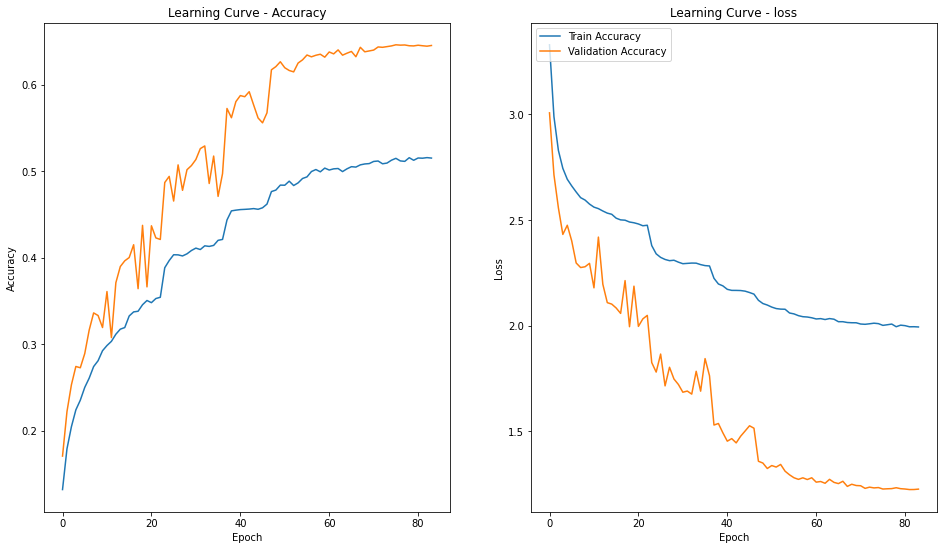

In [10]:
import matplotlib.pyplot as plt 
def plotlearningcurve(history):
    plt.figure(figsize = (16,9))
    plt.subplot(121)
    plt.plot(history.history['categorical_accuracy'] , label = 'Train Accuracy')
    plt.plot(history.history['val_categorical_accuracy'] , label = 'Validation Accuracy')
    plt.title('Learning Curve - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.subplot(122)
    plt.plot(history.history['loss'] , label = 'Train Accuracy')
    plt.plot(history.history['val_loss'] , label = 'Validation Accuracy')
    plt.title('Learning Curve - loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')


    plt.legend( loc='upper left')
    plt.show()

plotlearningcurve(history)

- First pleateau around 20 epochs,  causing the learning rate to be decreased 
- The model pleateauing at such an early number of epochs is concerning
- The dense net reaches 60% accuracy around epoch 55 after the learning rate was being decreased 3 times
- As the Learning Rate is being decreased many times, the loss and accuracy does not increase anymore 

Additional point:
- The dense net is very memory and computationally expensive to train with

Hence, considering the lower-than-expected validation score after so many epochs, I have decided to move on to try other models like the Wide Res Net 

In [11]:

class_analysis(densenet, X_val , y_val)

313/313 [==============================] - 6s 14ms/step
Accuracy 0.6449


,precision,recall,f1-score,support
reptiles,0.391892,0.485356,0.433645,478.0000
non-insect_invertebrates,0.422430,0.453815,0.437561,498.0000
small_mammals,0.516060,0.469786,0.491837,513.0000
medium_mammals,0.487524,0.515213,0.500986,493.0000
aquatic_mammals,0.434846,0.616183,0.509871,482.0000
large_carnivores,0.526316,0.521042,0.523666,499.0000
large_omnivores_and_herbivores,0.617521,0.567780,0.591607,509.0000
fish,0.602041,0.595960,0.598985,495.0000
vehicles_2,0.741071,0.504049,0.600000,494.0000
household_electrical_devices,0.589354,0.612648,0.600775,506.0000


Performs very poorly with f1 score of around for animal classes, with only 50% f1 score, which is close to guessing